# Vehicle Detection

The goal of this project is to identify and track vehicles in a test video. In this project will be using classical computer vision techniques (no deap learning) to accomplish this feat. This will involve:
* Developing Histogram of Oriented Gradients (HOG) features
* Developing histograms of color and color transform/binned features
* Using the features developed to train a SVM classifier
* Using a sliding window to go through each frame and search for vehicles using the classifier
* Creating a heatmap and finding a tight binding box around each car.
* Making a pipeline and tracking vehicles in the project video

## Data processing
The first step in training a classifier is data preprocessing. The labeled data are found in the vehicle and nonvehicle folder, and come from the GTI dataset [here](http://www.gti.ssr.upm.es/data/Vehicle_database.html) and the KITTI benchmark suite [here](http://www.cvlibs.net/datasets/kitti/). The data is grouped as vehicle and non-vehicle images, comprised of around 8800 images of vehicles and 8968 images of non-vehicles, so the data has slightly more non-vehicles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

%matplotlib inline

The number of car images are  8792
The number of non-car images are  8968


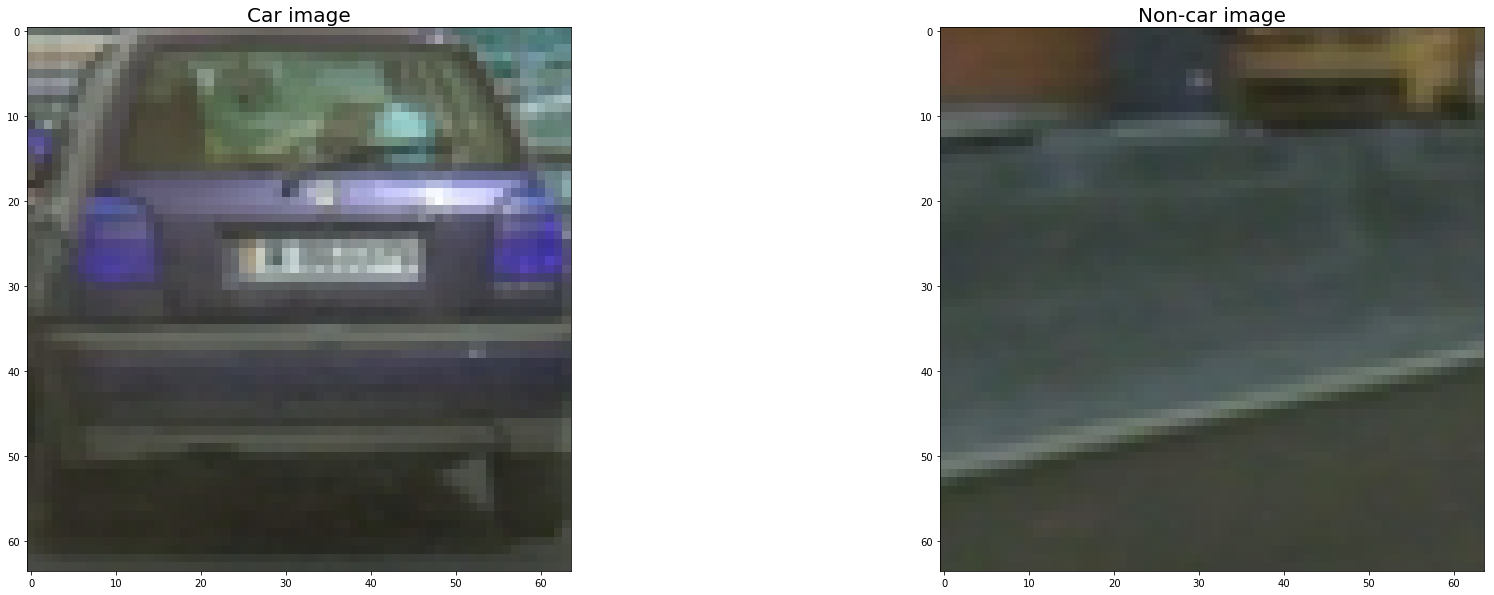

In [2]:
carfiles = glob.glob('./img_data/vehicles/*/*.png')
noncarfiles = glob.glob('./img_data/non-vehicles/*/*.png')

def get_images(input_file_name):
    images = []
    for filename in input_file_name:
        img = cv2.imread(filename)
        images.append(img)
    return images

def color_correct_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

cars = get_images(carfiles)
noncars = get_images(noncarfiles)
print('The number of car images are ', len(cars))
print('The number of non-car images are ', len(noncars))

testingfiles = glob.glob('./test_images/*.jpg')

test_img = get_images(testingfiles)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(cars[0], cmap='gray')
ax1.set_title('Car image', fontsize=20)
ax2.imshow(noncars[15], cmap='gray')
ax2.set_title('Non-car image', fontsize=20)
plt.savefig('output_images/car_not_car.jpg')

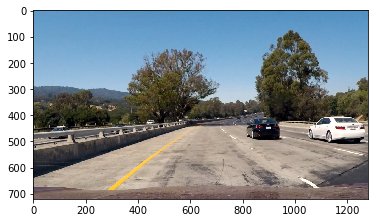

In [3]:
plt.imshow(color_correct_img(test_img[1]))

## Feature development
The next step is to define and develop the feature we are going to use for vehicle detection. The first feature is the histogram of gradients (hog) set. After that spatial features of the data will be generated, and finally color histograms will be calculated and used to match with our labeled dataset.


In [4]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Settings
This section is the main section that will be changed (along with windows later on) to fine tune the classifier. In this work, I have used a YCrCb colorspace (changed the input RGB/BGR channel to YCrCb) and all three channels (although the Y channel is the most important to use), and 16 histogram bins to put the colors in. 

The spatial size used is the default 32x32 size. 

Finally for the hog transformation I use 18 orientations for the gradients, 8 pixels per cell and 2 cells per block. This yielded the best results without increasing runtime too much.

In [5]:

colorspace = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
color_space = colorspace
orient = 18
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


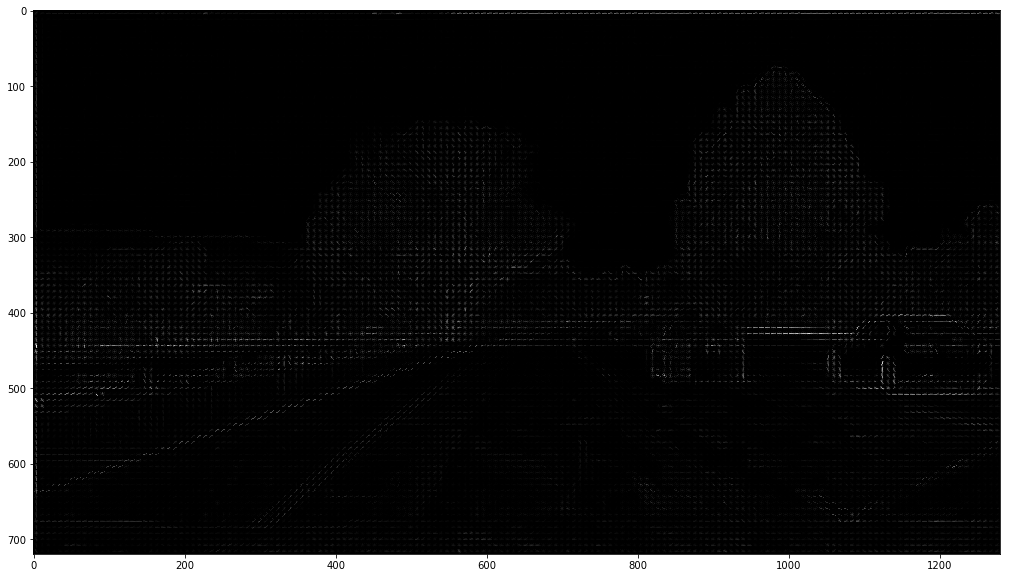

In [7]:
feature_image = test_img[1]
feature, hog_img_0 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.figure(figsize=(20,10))
plt.imshow(hog_img_0, cmap='gray')
plt.savefig('output_images/hog0.jpg')

## Train classifier
After choosing the settings, the next step is to train the classifier. In this stage, I first split the data into training and testing data, then generate the features for all images in the labeled dataset for both the car and non car set. After the features have been extracted for the two datasets, using a linear svc I train the classifier. It is important to remember to normalize the features and this is done by the StandardScaler method.

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.model_selection import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)
    

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows    


car_features = extract_features(carfiles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncarfiles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 13704
6.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


## Calibrate and undistort camera images
Since the camera is not perfect, I first calibrate and then find the undistortion matrix for the camera

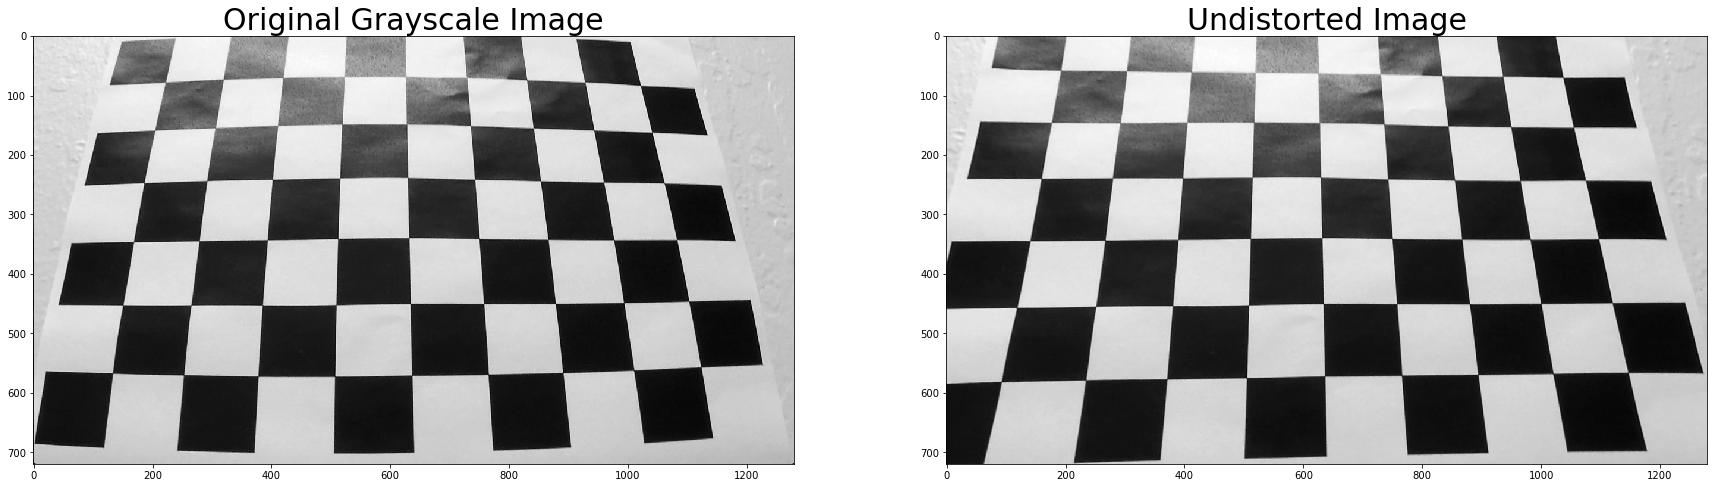

In [7]:
# prepare object points
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Make a list of calibration images using glob to import similarly named files
imagefiles = glob.glob("test_images/camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = [] # 3D points in real space
imgpoints = [] # 2D points in image plane

# Prepare object points (0,0,0), (0,1,0), (9,6,0) - all z's should be zero
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for filename in imagefiles:
    image = cv2.imread(filename)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        # Add object points
        objpoints.append(objp)
        # Add image points
        imgpoints.append(corners)
        
image = cv2.imread(imagefiles[13])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
undist = cv2.undistort(gray, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(gray, cmap='gray')
ax1.set_title('Original Grayscale Image', fontsize=30)
ax2.imshow(undist, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)

## Setup windows for sliding window search
After setting up all the necessary settings and methods, here we choose the windwos that will be searched in for the features mentioned above. The windows consist of smaller windows of 64x64 with a lot of overlap (0.85 in both x and y direction), a slightly bigger window of 92x92 and 0.8 overlap, and finally a 128x128 window with a 0.75 overlap. These windows are arranged in a matter such that the searching is done relative to car size, i.e. if the car is close and to the right we don't search for it in the 64x64 windows because those are for identifying cars that are further ahead.

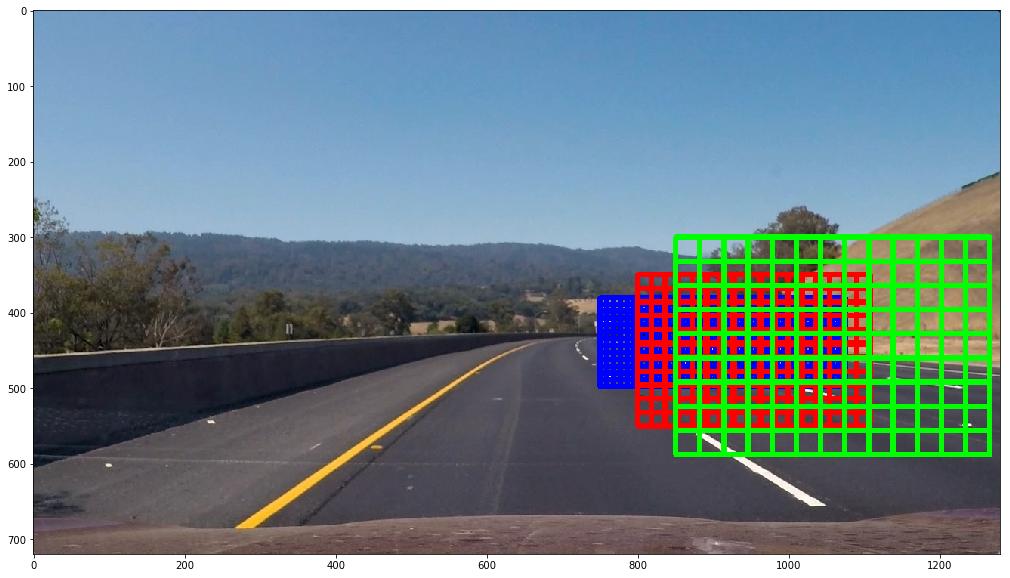

In [18]:
y_start_stop = [280, 600]
windows1 = slide_window(image, x_start_stop=[750, 1080], y_start_stop=[380,500], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))

windows2 = slide_window(image, x_start_stop=[800, 1120], y_start_stop=[350, 550], 
                    xy_window=(92, 92), xy_overlap=(0.8, 0.8))

windows3 = slide_window(image, x_start_stop=[850, None], y_start_stop=[300, 600], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))

#windows4 = slide_window(image, x_start_stop=[800, None], y_start_stop=y_start_stop, 
 #                   xy_window=(196, 196), xy_overlap=(0.5, 0.5))

# print(windows1, windows2, (windows1+windows2))
windows = windows1  + windows2 + windows3 #+ windows4

window_img = draw_boxes(draw_image, windows1, color=(0, 0, 255), thick=6)
window_img = draw_boxes(window_img, windows2, color=(255, 0, 0), thick=6)
window_img = draw_boxes(window_img, windows3, color=(0, 255, 0), thick=6)
plt.figure(figsize=(20,10))
plt.imshow(window_img)
plt.savefig('output_images/windows.jpg')

## Plotting the detected windows
An example of how these windows are used to detect vehicles is shown below.

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


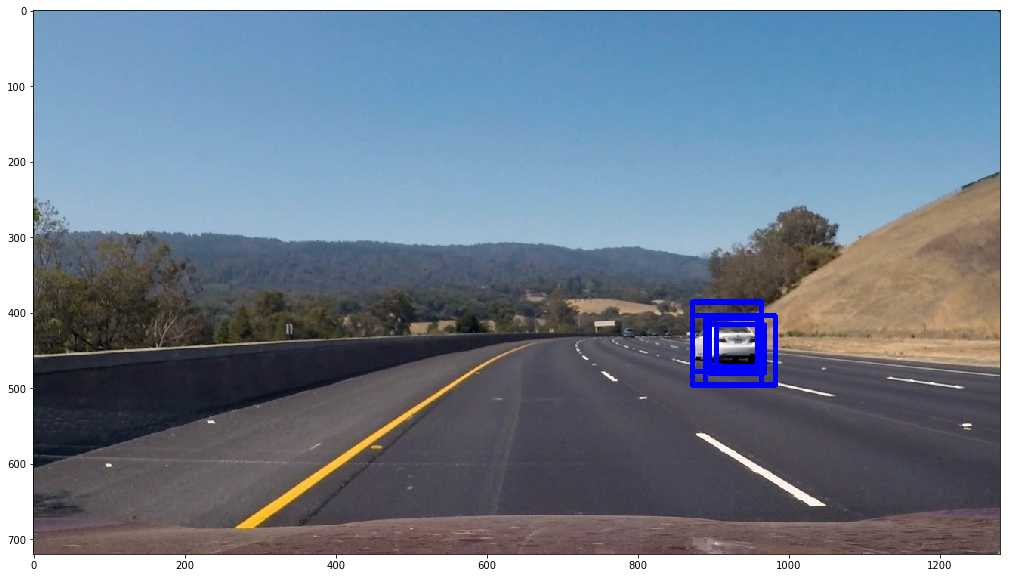

In [15]:
image = mpimg.imread(testingfiles[5])

draw_image = np.copy(image)

image = image.astype(np.float32)/255

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.figure(figsize=(20,10))
plt.imshow(window_img)
plt.savefig('output_images/vehicle_detection_example3.jpg')


## Generating a heatmap to combat multiple detections and false positives
The sliding window technique is prone to identifying a vehicle multiple times, and errounously identifying vehicles were there are non. In order to stop these false positives, and to combine all the multiple detections into one, we generate a heatmap where for all the places that a car is identified we add one to pixel value the window inside, and then set a threshold to announce car vs non-car.

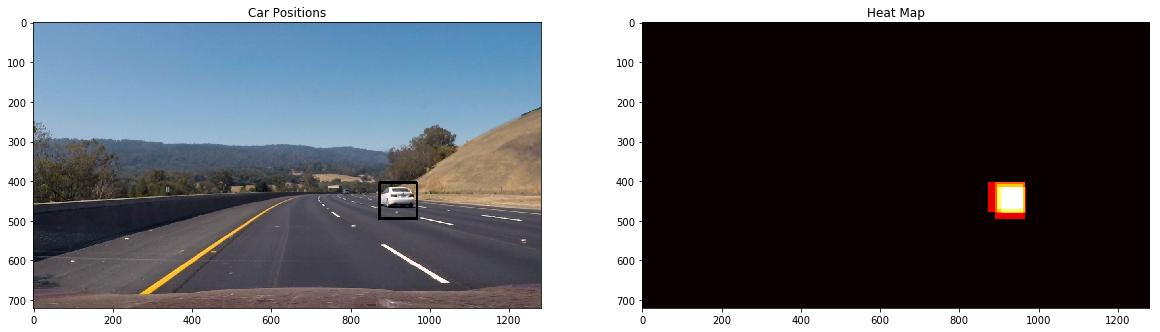

In [16]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    if bbox_list:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.savefig('output_images/detection_example3.jpg')


## Final setup and pipeline
After setting up the necessary steps for vehicle identification, two classes are generated one for the vehicle and one for the bounding boxes. The class for the vehilce is to track the heatmap and save the map from previous frames if needed, while the bounding box class is used to save the boxes from previous frames to use to generate new heatmaps. The combination of these two helps identify cars during shadow/color changes.

In [14]:
class vehicle():
    
    def __init__(self):
        self.current_heatmap = 0
        self.previous_heatmap = 0 
        self.avg_heatmap = 0
        self.threshold = 0
        
    def set_threshold(self, threshold):
        self.threshold = threshold
    
    def set_heatmap(self, heatmap):
        self.previous_heatmap = self.current_heatmap
        self.current_heatmap = heatmap
        self.update_heatmap()
        
    def return_avg_heatmap(self):
        return self.avg_heatmap
    
    def update_heatmap(self):
        self.current_heatmap = apply_threshold(self.current_heatmap, self.threshold)
        self.avg_heatmap = (0.75*self.avg_heatmap + 0.25*self.current_heatmap)
        self.avg_heatmap = apply_threshold(self.avg_heatmap, self.threshold)
        
    def update(self):
        self.current_heatmap = np.zeros_like(self.frame[:,:,0]).astype(np.float)
        self.previous_heatmap =np.zeros_like(self.frame[:,:,0]).astype(np.float)
        self.avg_heatmap = np.zeros_like(self.frame[:,:,0]).astype(np.float)
        
    #def boxcenter(self)

In [15]:
from collections import deque

class bounding_boxes:
    def __init__(self,n=10):
        self.n = n # length of queue to store data
        self.recent_boxes = deque([],maxlen=n) # hot windows of the last n images
        self.current_boxes = None
        self.boxes = []

    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
                 
    def set_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_boxes(self):        
        boxes = []
        for boxes in self.recent_boxes:
            boxes += boxes
        if len(boxes)==0:
            self.boxes = None
        else:
            self.boxes = boxes
            
    def update(self,boxes):
        self.set_boxes(boxes)
        self.add_boxes()
        self.get_boxes()


In [ ]:
vehicles = vehicle()
boxes = bounding_boxes(n=9)
vehicles.set_threshold(threshold=350)

def video_pipeline(img):    

    draw_image = np.copy(img)
    image = img.astype(np.float32)/255.
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    #window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)  
    boxes.update(hot_windows)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, boxes.boxes)

    
    vehicles.set_heatmap(heat)
    heatmap = vehicles.return_avg_heatmap()
       
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return(draw_img)


In [ ]:
from moviepy.editor import VideoFileClip

output = 'test_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(15,20)
output_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 37%|███▋      | 469/1261 [16:43<28:42,  2.18s/it]

In [ ]:
img = clip1.get_frame(9)


windows1 = slide_window(image, x_start_stop=[800, 1200], y_start_stop=[300, 600], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))

windows2 = slide_window(image, x_start_stop=[800, 1200], y_start_stop=[320, 550], 
                    xy_window=(92, 92), xy_overlap=(0.75, 0.75))

windows3 = slide_window(image, x_start_stop=[800, 1200], y_start_stop=[320,500], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))

windows4 = slide_window(image, x_start_stop=[800, None], y_start_stop=y_start_stop, 
                    xy_window=(196, 196), xy_overlap=(0.75, 0.75))

# print(windows1, windows2, (windows1+windows2))
windows = windows1  + windows2 + windows3 + windows4
   
draw_image = np.copy(img)
image = img.astype(np.float32)/255.

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

#window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)  
boxes.update(hot_windows)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat, boxes.boxes)


vehicles.set_heatmap(heat)
heatmap = vehicles.return_avg_heatmap()

labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.figure(figsize=(20,10))
plt.imshow(window_img)

In [ ]:


# Keeping this function for further use, not used in project
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

